In [5]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
from stats.reg import coefplot
from data.geo import meter_to_foot
from data.constants import WEB_CRS, LOCAL_CRS
import contextily as cx

In [7]:
point_panel_in = "../../../data/interim/point_panel.parquet"
line_panel_in = "../../../data/interim/line_panel.parquet"
tract_panel_in = "../../../data/interim/tract_panel.parquet"

poi_file_in = "../../../data/raw/poi_buildings.geojson"
train_stations_in = "../../../data/interim/train_stations.geojson"
train_lines_in = "../../../data/raw/train_lines.geojson"
bus_routes_in = "../../../data/raw/bus_routes.geojson"
bus_stops_in = "../../../data/interim/bus_stops.geojson"
bike_stations_in = "../../../data/interim/bike_stations_gbfs_v2.geojson"
tract_file_in = "../../../data/interim/tracts.geoparquet"
comm_file_in = "../../../data/interim/communities.geojson"

point_panel = pd.read_parquet(point_panel_in)
line_panel = pd.read_parquet(line_panel_in)
tract_panel = pd.read_parquet(tract_panel_in)

pois = gpd.read_file(poi_file_in)
train_stations = gpd.read_file(train_stations_in)
train_lines = gpd.read_file(train_lines_in)
bus_routes = gpd.read_file(bus_routes_in)
bus_stops = gpd.read_file(bus_stops_in)
bike_stations = gpd.read_file(bike_stations_in)
tracts = gpd.read_parquet(tract_file_in)
comms = gpd.read_file(comm_file_in)

In [8]:
poi_cols = list(point_panel.filter(regex="uc_|mp_").columns)
keep_cols = poi_cols + ['transit','rides','id','tid','DNC']
point_panel = point_panel.filter(keep_cols)
line_panel = line_panel.filter(keep_cols)
tract_panel = tract_panel.filter(keep_cols)

In [9]:
rides = pd.concat([point_panel, line_panel, tract_panel], keys=['point','line','tract'], names=['shape','index']).reset_index('shape')

In [10]:
rides = rides.groupby(poi_cols + ['shape','id','transit'])['rides'].sum().reset_index()

In [11]:
rides['UC400'] = (rides['uc_400'] > 0)
rides['UC800'] = (rides['uc_800'] > 0)
rides['UC1600'] = (rides['uc_1600'] > 0)
rides['MP400'] = (rides['mp_400'] > 0)
rides['MP800'] = (rides['mp_800'] > 0)
rides['MP1600'] = (rides['mp_1600'] > 0)
rides['UCMP400'] = (rides['uc_400'] > 0) | (rides['mp_400'] > 0)
rides['UCMP800'] = (rides['uc_800'] > 0) | (rides['mp_800'] > 0)
rides['UCMP1600'] = (rides['uc_1600'] > 0) | (rides['mp_1600'] > 0)
rides = rides.drop(columns=poi_cols)


# Sample Size

In [12]:
rides.drop(columns=['id','rides']).groupby(['shape','transit']).agg(['sum','mean'])
# Nevertheless, I stand by using the 1600m because there are barely enough observations in that one,
# certainly not enough in the 800 and 400m.

UC400           UC800           UC1600           MP400  \
                sum      mean   sum      mean    sum      mean   sum   
shape transit                                                          
line  bus         4  0.032000     7  0.056000     13  0.104000     2   
      train       0  0.000000     3  0.375000      3  0.375000     0   
point bike        2  0.001209     5  0.003023     27  0.016324     2   
      train       0  0.000000     3  0.020833      6  0.041667     0   
tract bike        3  0.004587     7  0.010703     22  0.033639     3   
      train       2  0.017544     5  0.043860      8  0.070175     1   
      uber        4  0.003165     9  0.007120     27  0.021361     1   

                        MP800           MP1600           UCMP400            \
                   mean   sum      mean    sum      mean     sum      mean   
shape transit                                                                
line  bus      0.016000     6  0.048000     13  0.104000       6  0.048000   
      train    0.000000     1  0.125000      2  0.250000       0  0.000000   
point bike     0.001209     7  0.004232     20  0.012092       4  0.002418   
      train    0.000000     1  0.006944      2  0.013889       0  0.000000   
tract bike     0.004587     6  0.009174     15  0.022936       6  0.009174   
      train    0.008772     2  0.017544      6  0.052632       3  0.026316   
      uber     0.000791     4  0.003165     13  0.010285       5  0.003956   

              UCMP800           UCMP1600            
                  sum      mean      sum      mean  
shape transit                                       
line  bus          13  0.104000       25  0.200000  
      train         3  0.375000        4  0.500000  
point bike         12  0.007255       47  0.028416  
      train         4  0.027778        8  0.055556  
tract bike         13  0.019878       37  0.056575  
      train         7  0.061404       14  0.122807  
      uber         13  0.010285       40  0.031646

# Sensitivity

In [13]:
uc_cols = list(rides.filter(like="UC").columns)
mp_cols = list(rides.filter(like="MP").columns)
ucmp_cols = list(rides.filter(like="UCMP").columns)
uc_cols = [x for x in uc_cols if x not in ucmp_cols]
mp_cols = [x for x in mp_cols if x not in ucmp_cols]

rhs = " + ".join(uc_cols + mp_cols)
model = sm.OLS.from_formula(f"rides ~ {rhs}", rides).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     28.46
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           1.73e-33
Time:                        15:33:20   Log-Likelihood:                -70974.
No. Observations:                3963   AIC:                         1.420e+05
Df Residuals:                    3956   BIC:                         1.420e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.073e+05   2.36e+05      0.455      0.649   -3.55e+05     5.7e+05
UC400[T.True]  -3.139e+07   4.78e+06     -6.565      0.000   -4.08e+07    -2.2e+07
UC800[T.True]   3.181e+07   3.46e+06      9.200      0.000     2.5e+07    3.86e+07
UC1600[T.True] -1.605e+05   1.79e+06     -0.090      0.929   -3.67e+06    3.35e+06
MP400[T.True]  -4.691e+06   5.93e+06     -0.791      0.429   -1.63e+07    6.94e+06
MP800[T.True]  -1.119e+07   4.07e+06     -2.752      0.006   -1.92e+07   -3.22e+06
MP1600[T.True]  1.636e+07    2.2e+06      7.431      0.000     1.2e+07    2.07e+07
==============================================================================
Omnibus:                    11692.152   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        558050401.641
Skew:                          41.267   Prob(JB):                         0.00
Kurtosis:                    1839.505   Cond. No.                         27.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

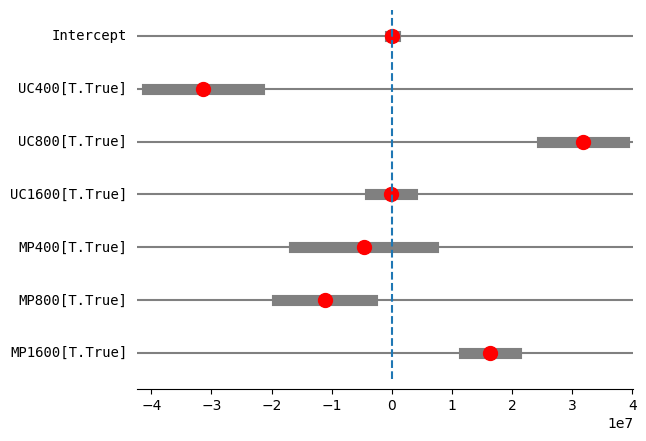

In [14]:
coefplot(model);
# Results are opposite for UC and MP. Direction is inconsistent as buffer changes.
# Indicates results are sensitive to buffer.

In [15]:
rhs = " + ".join(uc_cols + mp_cols)
model = sm.OLS.from_formula(f"rides ~ shape * ({rhs})", rides).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     45.25
Date:                Tue, 10 Dec 2024   Prob (F-statistic):          4.35e-160
Time:                        15:33:21   Log-Likelihood:                -70648.
No. Observations:                3963   AIC:                         1.413e+05
Df Residuals:                    3942   BIC:                         1.415e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      3.302e+06    1.3e+06      2.530      0.011    7.43e+05    5.86e+06
shape[T.point]                -3.259e+06   1.34e+06     -2.425      0.015   -5.89e+06   -6.24e+05
shape[T.tract]                -3.232e+06   1.34e+06     -2.412      0.016   -5.86e+06   -6.05e+05
UC400[T.True]                 -1.262e+08   8.71e+06    -14.484      0.000   -1.43e+08   -1.09e+08
UC800[T.True]                  1.406e+08   7.84e+06     17.922      0.000    1.25e+08    1.56e+08
UC1600[T.True]                -1.658e+07   5.64e+06     -2.940      0.003   -2.76e+07   -5.52e+06
MP400[T.True]                  2.063e+06   1.13e+07      0.183      0.855      -2e+07    2.42e+07
MP800[T.True]                 -9.197e+07   7.75e+06    -11.867      0.000   -1.07e+08   -7.68e+07
MP1600[T.True]                 8.877e+07   4.93e+06     18.015      0.000    7.91e+07    9.84e+07
shape[T.point]:UC400[T.True]    1.26e+08    1.4e+07      9.013      0.000    9.86e+07    1.53e+08
shape[T.tract]:UC400[T.True]   1.258e+08   1.05e+07     11.949      0.000    1.05e+08    1.46e+08
shape[T.point]:UC800[T.True]  -1.405e+08   9.93e+06    -14.145      0.000    -1.6e+08   -1.21e+08
shape[T.tract]:UC800[T.True]  -1.401e+08   9.03e+06    -15.526      0.000   -1.58e+08   -1.22e+08
shape[T.point]:UC1600[T.True]  1.657e+07   6.25e+06      2.651      0.008    4.31e+06    2.88e+07
shape[T.tract]:UC1600[T.True]  1.659e+07   6.07e+06      2.731      0.006    4.68e+06    2.85e+07
shape[T.point]:MP400[T.True]  -2.108e+06   1.57e+07     -0.134      0.893   -3.29e+07    2.87e+07
shape[T.tract]:MP400[T.True]  -2.139e+06   1.37e+07     -0.156      0.876   -2.91e+07    2.48e+07
shape[T.point]:MP800[T.True]   9.197e+07   1.01e+07      9.070      0.000    7.21e+07    1.12e+08
shape[T.tract]:MP800[T.True]   9.207e+07   9.69e+06      9.503      0.000    7.31e+07    1.11e+08
shape[T.point]:MP1600[T.True] -8.875e+07    6.1e+06    -14.550      0.000   -1.01e+08   -7.68e+07
shape[T.tract]:MP1600[T.True] -8.867e+07    5.7e+06    -15.547      0.000   -9.99e+07   -7.75e+07
==============================================================================
Omnibus:                    10855.950   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        374096037.455
Skew:                          33.755   Prob(JB):                         0.00
Kurtosis:                    1506.654   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

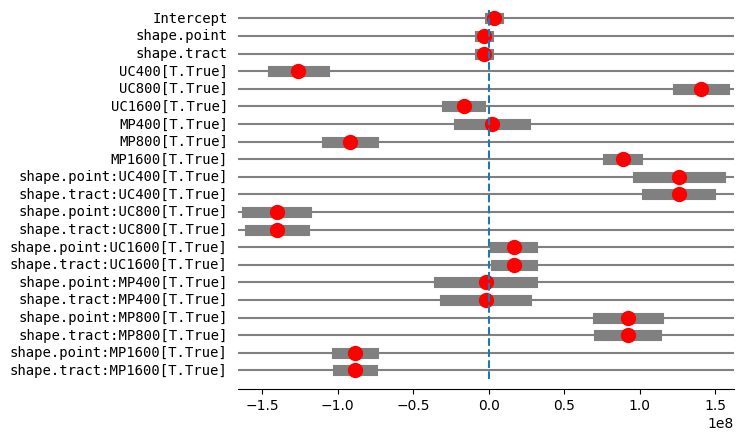

In [16]:
coefplot(model);
# Same observations hold when comparing transit types.

In [17]:
rhs = " + ".join(ucmp_cols)
model = sm.OLS.from_formula(f"rides ~ shape * ({rhs})", rides).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     46.11
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           1.82e-95
Time:                        15:33:22   Log-Likelihood:                -70819.
No. Observations:                3963   AIC:                         1.417e+05
Df Residuals:                    3951   BIC:                         1.417e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2.548e+06   1.37e+06      1.860      0.063   -1.38e+05    5.23e+06
shape[T.point]                  -2.505e+06   1.41e+06     -1.776      0.076   -5.27e+06     2.6e+05
shape[T.tract]                  -2.479e+06   1.41e+06     -1.763      0.078   -5.24e+06    2.78e+05
UCMP400[T.True]                 -7.507e+07   7.21e+06    -10.406      0.000   -8.92e+07   -6.09e+07
UCMP800[T.True]                  2.059e+07   5.88e+06      3.503      0.000    9.07e+06    3.21e+07
UCMP1600[T.True]                 5.341e+07   4.11e+06     12.995      0.000    4.54e+07    6.15e+07
shape[T.point]:UCMP400[T.True]   7.499e+07   1.08e+07      6.929      0.000    5.38e+07    9.62e+07
shape[T.tract]:UCMP400[T.True]   7.479e+07   8.73e+06      8.564      0.000    5.77e+07    9.19e+07
shape[T.point]:UCMP800[T.True]  -2.054e+07   7.47e+06     -2.750      0.006   -3.52e+07    -5.9e+06
shape[T.tract]:UCMP800[T.True]  -2.028e+07   6.94e+06     -2.922      0.003   -3.39e+07   -6.67e+06
shape[T.point]:UCMP1600[T.True] -5.341e+07   4.69e+06    -11.384      0.000   -6.26e+07   -4.42e+07
shape[T.tract]:UCMP1600[T.True] -5.337e+07   4.51e+06    -11.828      0.000   -6.22e+07   -4.45e+07
==============================================================================
Omnibus:                    11293.306   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        453285055.559
Skew:                          37.548   Prob(JB):                         0.00
Kurtosis:                    1658.132   Cond. No.                         83.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

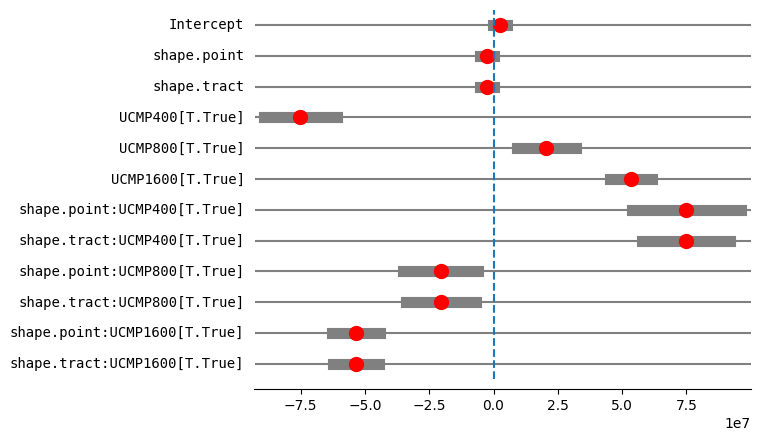

In [18]:
coefplot(model);
# Same observations hold when aggregating both POIs.

# Sample Plot

In [19]:
train_lines['line'] = train_lines['line'].str.strip()

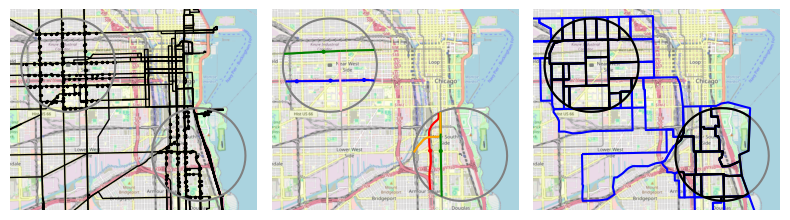

In [39]:
fig, axs = plt.subplots(1,3, figsize=(8,4))
buffer = pois.to_crs(LOCAL_CRS).buffer(meter_to_foot(1600)).to_crs(WEB_CRS)
for ax in axs:
    pois.to_crs(WEB_CRS).plot(ax=ax, color='grey', zorder=2)
    buffer.boundary.plot(ax=ax, color='grey', zorder=2)
    cx.add_basemap(ax, attribution=False)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

bus_stops.to_crs(WEB_CRS).clip(buffer).plot(ax=axs[0], color='black', markersize=2)
plot_bus_routes = bus_routes[bus_routes.to_crs(WEB_CRS).intersects(buffer.union_all())]
plot_bus_routes.to_crs(WEB_CRS).plot(ax=axs[0], color='black', zorder=1, linewidth=1)

plot_train_stations = train_stations.assign(color = train_stations['line'].str.split(',').apply(lambda x: x[0]))
plot_train_stations = plot_train_stations[plot_train_stations.to_crs(WEB_CRS).intersects(buffer.union_all())]
plot_train_stations.to_crs(WEB_CRS).plot(ax=axs[1], color=plot_train_stations['color'], markersize=4)

plot_train_lines = train_lines.assign(line = train_lines['line'].str.strip())
plot_train_lines = plot_train_lines.to_crs(WEB_CRS).clip(buffer)
plot_train_lines.plot(ax=axs[1], color=plot_train_lines['line'])
# sample_train_lines = plot_train_lines[plot_train_lines.to_crs(WEB_CRS).intersects(buffer.union_all())].line.unique()
# plot_train_lines = plot_train_lines[plot_train_lines.line.isin(sample_train_lines)]
# plot_train_lines.to_crs(WEB_CRS).plot(ax=axs[1], color=plot_train_lines['line'])

tracts[(tracts.uc_1600==1)|(tracts.mp_1600==1)].to_crs(WEB_CRS).boundary.plot(ax=axs[2], color='blue');
tracts.to_crs(WEB_CRS).clip(buffer).boundary.plot(ax=axs[2], color='black');

fig.tight_layout()
plt.savefig("../../../reports/replication/panel_sample.jpeg")

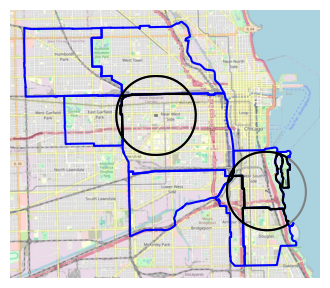

In [31]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

pois.to_crs(WEB_CRS).plot(ax=ax, color='grey', zorder=2)
buffer.boundary.plot(ax=ax, color='grey', zorder=2)
comms[(comms.uc_1600==1)|(comms.mp_1600==1)].to_crs(WEB_CRS).boundary.plot(ax=ax, color='blue')
comms.to_crs(WEB_CRS).clip(buffer).boundary.plot(ax=ax, color='black')

cx.add_basemap(ax, attribution=False)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.savefig("../../../reports/replication/comms_sample.jpeg")
!cp ../../../reports/replication/comms_sample.jpeg ../../../../eric-mc2-cv/static/img/

In [37]:
clipped = comms.to_crs(LOCAL_CRS).clip(pois.to_crs(LOCAL_CRS).buffer(meter_to_foot(1600))).area.sum()
extra = comms.to_crs(LOCAL_CRS)[(comms.uc_1600==1)|(comms.mp_1600==1)].area.sum()
print("Within / Intersected {:.2%}".format(clipped/extra))

Within / Intersected 25.99%


In [38]:
clipped = tracts.to_crs(LOCAL_CRS).clip(pois.to_crs(LOCAL_CRS).buffer(meter_to_foot(1600))).area.sum()
extra = tracts.to_crs(LOCAL_CRS)[(tracts.uc_1600==1)|(tracts.mp_1600==1)].area.sum()
print("Within / Intersected {:.2%}".format(clipped/extra))

Within / Intersected 50.05%
